# Topic Modeling & Anxiety-Level Exploration
## Objective
Validate whether NMF-based topic modeling combined with the NRC Emotion Lexicon (anxiety) provides useful, reliable signals on our corpus.

## Step 1 — Feasibility Check
- Load posts with embedded top comments from data/raw/posts_with_comments_YYYYMMDD.jsonl.
- Build a DataFrame with post metadata and a combined text field: title + selftext + top_comments.
- Normalize text (lowercase, remove URLs, strip punctuation; optionally expand contractions and remove domain-specific stopwords).
- Create TF–IDF features and fit an NMF model to discover topics.
- Apply NRC to score anxiety and validate with human review (spot-check examples for face validity).

## Step 2 — Improve Topic Quality
- Tune vectorization (n-grams, min_df/max_df, stopword list).
- Tune NMF (n_components, initialization, regularization).
- Compare with simple baselines (e.g., LSA) and track topic coherence + human interpretability.

## Step 3 — Triage & Fixes
- Address data quality issues (duplicates, encoding, missing fields).
- Log errors and decisions; re-run as needed.

In [1]:
import json
from pathlib import Path
from typing import List, Dict, Any
import pandas as pd

In [2]:
def load_jsonl(path: Path) -> List[Dict[str, Any]]:
    rows: List[Dict[str, Any]] = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return rows


def to_dataframe(records: List[Dict[str, Any]]) -> pd.DataFrame:
    # Extract required fields; coerce missing keys to None
    def extract(r: Dict[str, Any]) -> Dict[str, Any]:
        top_comments = r.get("top_comments") or []
        # Keep only comment bodies for compactness
        comment_bodies = [c.get("body") for c in top_comments if isinstance(c, dict)]
        return {
            "post_id": r.get("post_id"),
            "url": r.get("url"),
            "subreddit": r.get("subreddit"),
            "created_utc": r.get("created_utc"),
            "title": r.get("title"),
            "selftext": r.get("selftext"),
            "score": r.get("score"),
            "num_comments": r.get("num_comments"),
            "upvote_ratio": r.get("upvote_ratio"),
            "over_18": r.get("over_18"),
            # Keep list of strings (comment bodies)
            "top3_comments": comment_bodies,
        }

    df = pd.DataFrame([extract(r) for r in records])
    return df

In [3]:
records = load_jsonl(Path("../data/raw/posts_with_comments_20250916.jsonl"))
raw_data = to_dataframe(records)

raw_data.to_csv("../data/processed/reddit_posts_with_comments_20250916.csv", index=False)

raw_data.head()

,post_id,url,subreddit,created_utc,title,selftext,score,num_comments,upvote_ratio,over_18,top3_comments
0,1niyxl5,https://www.reddit.com/r/artificial/comments/1...,artificial,1.758070e+09,/–|\,,6,1,1.00,False,"[Oh, this is very nice]"
1,1niwfc7,https://www.reddit.com/r/artificial/comments/1...,artificial,1.758063e+09,Millions turn to AI chatbots for spiritual gui...,,18,12,0.91,False,[I don't know what to say here. People are des...
2,1nirter,https://www.reddit.com/r/artificial/comments/1...,artificial,1.758052e+09,Anthropic data confirms Gen Z’s worst fears ab...,,13,3,0.84,False,"[It was predictable, who doesn't know CEOs tha..."
3,1nipc4n,https://www.reddit.com/r/artificial/comments/1...,artificial,1.758047e+09,The future danger isn’t a sci-fi superintellig...,"Every algorithm has a designer, and every desi...",26,9,0.86,False,[Plot twist: it's both. They're both real dang...
4,1ninkf4,https://www.reddit.com/r/artificial/comments/1...,artificial,1.758043e+09,‘I have to do it’: Why one of the world’s most...,,26,7,0.73,False,"[Honey look, New God father of AI just dropped..."


In [4]:
len(raw_data)

50

### Tokenize posts

In [5]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk
import emoji

# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict for replacement
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
stop_words = ENGLISH_STOP_WORDS

# List of punctuation
punc = list(set(string.punctuation))

def casual_tokenizer(text):
    """Tokenizer that preserves contractions and most punctuation."""
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens

def expandContractions(text, c_re=c_re):
    """Expand contractions in text using c_re."""
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)


def emojis_to_text(text: str) -> str:
    """
    Replace emojis with descriptive words (e.g., :smiling_face:) and
    add spaces around them so tokenizers split cleanly.
    If the emoji package is unavailable, return the original text.
    """
    if emoji is None:
        return text
    try:
        return emoji.demojize(text, language="en", delimiters=(" ", " "))
    except Exception:
        return text

def process_text(text):
    """
    Preprocess the input text by tokenizing, normalizing, and removing unwanted elements.
    """
    text = emojis_to_text(text)
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [expandContractions(each, c_re=c_re) for each in text]
    text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text

In [6]:
df = raw_data.copy()
# combine title, selftext, and top3_comments into a single text field
df['fulltext'] = df['title'].fillna('') + ' ' + df['selftext'].fillna('') + ' ' + df['top3_comments'].fillna('').apply(lambda comments: ' '.join(comments) if isinstance(comments, list) else '')
# process the full text
df['processed_full_text'] = df['fulltext'].apply(process_text)
df.head()

,post_id,url,subreddit,created_utc,title,selftext,score,num_comments,upvote_ratio,over_18,top3_comments,fulltext,processed_full_text
0,1niyxl5,https://www.reddit.com/r/artificial/comments/1...,artificial,1.758070e+09,/–|\,,6,1,1.00,False,"[Oh, this is very nice]","/–|\ Oh, this is very nice","[oh, veri, nice]"
1,1niwfc7,https://www.reddit.com/r/artificial/comments/1...,artificial,1.758063e+09,Millions turn to AI chatbots for spiritual gui...,,18,12,0.91,False,[I don't know what to say here. People are des...,Millions turn to AI chatbots for spiritual gui...,"[million, turn, ai, chatbot, spiritu, guidanc,..."
2,1nirter,https://www.reddit.com/r/artificial/comments/1...,artificial,1.758052e+09,Anthropic data confirms Gen Z’s worst fears ab...,,13,3,0.84,False,"[It was predictable, who doesn't know CEOs tha...",Anthropic data confirms Gen Z’s worst fears ab...,"[anthrop, data, confirm, gen, worst, fear, ai,..."
3,1nipc4n,https://www.reddit.com/r/artificial/comments/1...,artificial,1.758047e+09,The future danger isn’t a sci-fi superintellig...,"Every algorithm has a designer, and every desi...",26,9,0.86,False,[Plot twist: it's both. They're both real dang...,The future danger isn’t a sci-fi superintellig...,"[futur, danger, isn, sci-fi, superintellig, de..."
4,1ninkf4,https://www.reddit.com/r/artificial/comments/1...,artificial,1.758043e+09,‘I have to do it’: Why one of the world’s most...,,26,7,0.73,False,"[Honey look, New God father of AI just dropped...",‘I have to do it’: Why one of the world’s most...,"[whi, world, brilliant, ai, scientist, left, c..."


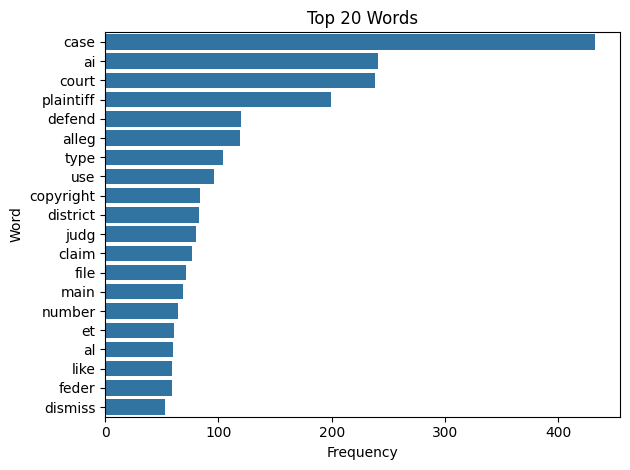

In [7]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top20_words():
    words = [w.lower() for row in df['processed_full_text'].dropna() for w in row]
    top = Counter(words).most_common(20)
    words, counts = zip(*top) if top else ([], [])
    sns.barplot(x=list(counts), y=list(words))
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.title('Top 20 Words')
    plt.tight_layout()
    
    plt.show()

plot_top20_words()

We may need to extend the list of stop words to avoid meaningless words such as case, ai, type, use...

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

texts = df['processed_full_text']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Run the nmf model
nmf = NMF(
    n_components=10,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha_W=0.0,
    tol=1e-4,
    random_state=42
)

doc_topic = nmf.fit_transform(tfidf)
topic_word = nmf.components_

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
top_words_idx = np.argsort(topic_word, axis=1)[:, ::-1][:, :10]
top_words = [feature_names[idx].tolist() for idx in top_words_idx]
topic_labels = [" ".join(words[:5]) for words in top_words]

top_topic = np.argmax(doc_topic, axis=1)
top_score = doc_topic[np.arange(doc_topic.shape[0]), top_topic]
assignments = pd.DataFrame({
    "topic": top_topic,
    "score": top_score,
    "label": [topic_labels[t] for t in top_topic],
}, index=df.index)


assignments_renamed = assignments.rename(
    columns={"topic": "nmf_topic", "score": "nmf_score", "label": "nmf_label"}
)
df = df.join(assignments_renamed[["nmf_topic", "nmf_score", "nmf_label"]])

df.head()


,post_id,url,subreddit,created_utc,title,selftext,score,num_comments,upvote_ratio,over_18,top3_comments,fulltext,processed_full_text,nmf_topic,nmf_score,nmf_label
0,1niyxl5,https://www.reddit.com/r/artificial/comments/1...,artificial,1.758070e+09,/–|\,,6,1,1.00,False,"[Oh, this is very nice]","/–|\ Oh, this is very nice","[oh, veri, nice]",8,0.183450,self ai claud advanc correct
1,1niwfc7,https://www.reddit.com/r/artificial/comments/1...,artificial,1.758063e+09,Millions turn to AI chatbots for spiritual gui...,,18,12,0.91,False,[I don't know what to say here. People are des...,Millions turn to AI chatbots for spiritual gui...,"[million, turn, ai, chatbot, spiritu, guidanc,...",7,0.361312,project say chat work use
2,1nirter,https://www.reddit.com/r/artificial/comments/1...,artificial,1.758052e+09,Anthropic data confirms Gen Z’s worst fears ab...,,13,3,0.84,False,"[It was predictable, who doesn't know CEOs tha...",Anthropic data confirms Gen Z’s worst fears ab...,"[anthrop, data, confirm, gen, worst, fear, ai,...",0,0.283513,ai know race like job
3,1nipc4n,https://www.reddit.com/r/artificial/comments/1...,artificial,1.758047e+09,The future danger isn’t a sci-fi superintellig...,"Every algorithm has a designer, and every desi...",26,9,0.86,False,[Plot twist: it's both. They're both real dang...,The future danger isn’t a sci-fi superintellig...,"[futur, danger, isn, sci-fi, superintellig, de...",5,0.304631,data model planet think peopl
4,1ninkf4,https://www.reddit.com/r/artificial/comments/1...,artificial,1.758043e+09,‘I have to do it’: Why one of the world’s most...,,26,7,0.73,False,"[Honey look, New God father of AI just dropped...",‘I have to do it’: Why one of the world’s most...,"[whi, world, brilliant, ai, scientist, left, c...",0,0.262124,ai know race like job


Need to work on NMF model to improve the accuracy of nmf_label.